
## MetObs API key (keep private)
2a0bf9fc-ab9c-4616-bb48-21ca990be16f



# Assignment roadmap
- Scope: compare forecast models vs measured GHI for station 06072; compute RMSE & bias per horizon; produce plots and poster-ready figures.
- Data cadence: forecasts hourly/right-binned; measurements 10 min/right-labeled -> resample to hourly.
- Keys: keep everything in UTC; align on forecast issue time + horizon.



## 1) Measurement data (DMI MetObs)
- Download 10-min GHI for station 06072 via API key; basic QC (BSRN min/max).
- Resample to 1h mean (`df.resample('1H', label='right', closed='right').mean()`).
- Save cleaned hourly series for reuse.



### Load hourly measurements
Load resampled station observations (`station_data_hourly.csv`).


In [181]:

obs_path = Path('station_data_hourly.csv')
obs_hourly = pd.read_csv(obs_path, parse_dates=['time'])

print(f'Loaded {len(obs_hourly)} hourly rows from {obs_path}')
display(obs_hourly.head())


Loaded 384 hourly rows from station_data_hourly.csv


,time,ghi
0,2025-11-08 01:00:00+00:00,0.0
1,2025-11-08 02:00:00+00:00,0.0
2,2025-11-08 03:00:00+00:00,0.0
3,2025-11-08 04:00:00+00:00,0.0
4,2025-11-08 05:00:00+00:00,0.0



## 2) Forecast data (open-meteo files)
- Load all `06072_YYYYMMDDT0600.csv` files; parse `date` as datetime (UTC).
- Long-form melt for stacking models; track forecast issue time for horizons.
- Note model horizons differ (e.g., Harmonie ~54h, ECMWF IFS ~10d).



### Setup
Imports and common paths.


In [182]:

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

data_dir = Path("ForcastData")
files = sorted(data_dir.glob("06072_*.csv"))
print(f"Found {len(files)} forecast files in {data_dir}")


Found 11 forecast files in ForcastData



### Load all forecasts and reshape
- Load every `06072_YYYYMMDDT0600.csv` in `ForcastData`.
- Add `issue_time` from filename; compute `horizon_hours = date - issue_time`.
- Melt wide model columns into long `model`/`forecast` for easier grouping and metrics.


In [183]:

from typing import List


def issue_from_name(path: Path) -> pd.Timestamp:
    ts = path.stem.split('_')[1]  # e.g., 20251108T0600
    return pd.to_datetime(ts, format="%Y%m%dT%H%M", utc=True)

frames: List[pd.DataFrame] = []
for f in files:
    issue_time = issue_from_name(f)
    df_tmp = pd.read_csv(f, parse_dates=["date"])
    df_tmp["issue_time"] = issue_time
    df_tmp["horizon_hours"] = (df_tmp["date"] - df_tmp["issue_time"]).dt.total_seconds() / 3600
    long_tmp = df_tmp.melt(
        id_vars=["date", "issue_time", "horizon_hours"],
        var_name="model",
        value_name="forecast"
    )
    long_tmp["source_file"] = f.name
    frames.append(long_tmp)

all_forecasts = pd.concat(frames, ignore_index=True)
print("Loaded rows:", len(all_forecasts))
display(all_forecasts.head())

# Quick check: max horizon per model to understand coverage
max_h = all_forecasts.groupby("model")["horizon_hours"].max().sort_values()
print("\nMax horizon (hours) per model:\n", max_h)


Loaded rows: 14784


,date,issue_time,horizon_hours,model,forecast,source_file
0,2025-11-08 00:00:00+00:00,2025-11-08 06:00:00+00:00,-6.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv
1,2025-11-08 01:00:00+00:00,2025-11-08 06:00:00+00:00,-5.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv
2,2025-11-08 02:00:00+00:00,2025-11-08 06:00:00+00:00,-4.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv
3,2025-11-08 03:00:00+00:00,2025-11-08 06:00:00+00:00,-3.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv
4,2025-11-08 04:00:00+00:00,2025-11-08 06:00:00+00:00,-2.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv



Max horizon (hours) per model:
 model
dmi_harmonie_arome_europe    161.0
dmi_seamless                 161.0
ecmwf_aifs025_single         161.0
ecmwf_ifs                    161.0
ecmwf_ifs025                 161.0
gfs_global                   161.0
gfs_seamless                 161.0
metno_nordic                 161.0
Name: horizon_hours, dtype: float64



### Quick single-file preview & plot
Plot one forecast file to see model shapes.


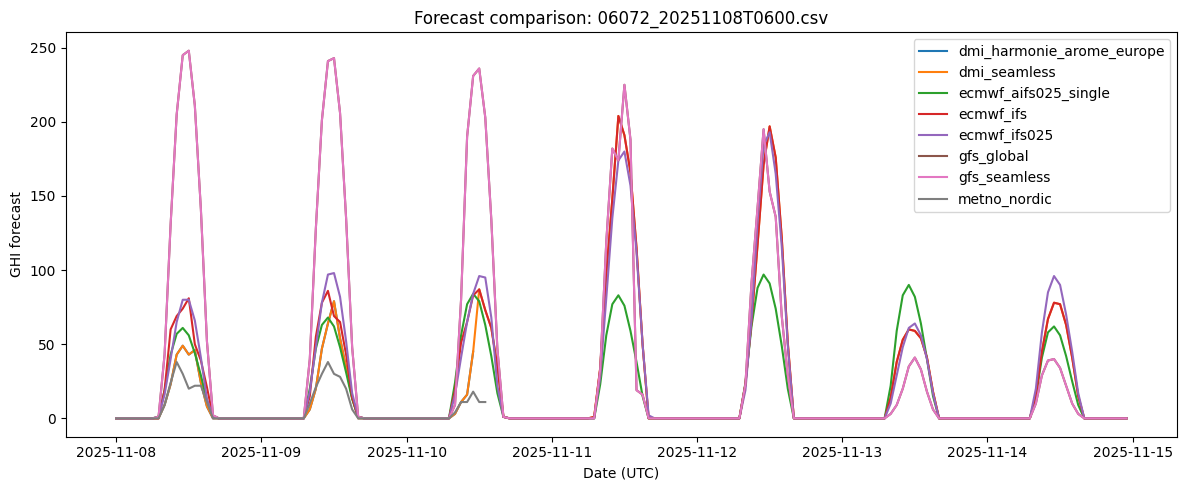

In [184]:

if not files:
    raise ValueError("No forecast files found")

first_file = files[0] # write 0-10 to plot the diffrent files
df_single = pd.read_csv(first_file, parse_dates=["date"])
long_single = df_single.melt(id_vars="date", var_name="model", value_name="forecast")

plt.figure(figsize=(12, 5))
for model, grp in long_single.groupby("model"):
    plt.plot(grp["date"], grp["forecast"], label=model, linewidth=1.5)

plt.xlabel("Date (UTC)")
plt.ylabel("GHI forecast")
plt.title(f"Forecast comparison: {first_file.name}")
plt.legend()
plt.tight_layout()
plt.show()



## 3) Align forecasts vs measurements
- Build forecast horizon `h = date - issue_time` per file; drop negative/NaN.
- Inner-join forecasts with hourly measurements on timestamp.
- Ensure right-edge alignment: forecast hour 02:00 covers 01:01-02:00.



### Align forecasts with measurements
Join forecasts to hourly observations on timestamp and filter valid horizons.


In [185]:

# Prepare observations with a matching timestamp column
obs_ready = obs_hourly.rename(columns={'time': 'date'}).copy()
obs_ready['date'] = pd.to_datetime(obs_ready['date'], utc=True)
obs_ready = obs_ready[['date', 'ghi']]

# Join forecasts with observations on timestamp
aligned = all_forecasts.merge(obs_ready, on='date', how='inner')

# Keep only non-negative horizons and valid values
aligned = aligned[aligned['horizon_hours'] >= 0].dropna(subset=['forecast', 'ghi']).copy()
aligned['error'] = aligned['forecast'] - aligned['ghi']

print(f"Aligned rows: {len(aligned)}")
print(aligned[['model', 'horizon_hours']].groupby('model').size().head())
display(aligned.head())


# Model coverage check
model_counts = aligned.groupby("model").size().sort_values(ascending=False)
print("Rows per model (top 10):", model_counts.head(10))
unique_models = aligned["model"].unique()
print(f"Total models in aligned data: {len(unique_models)} -> {sorted(unique_models)[:5]} ...")


Aligned rows: 11764
model
dmi_harmonie_arome_europe     594
dmi_seamless                 1759
ecmwf_aifs025_single         1759
ecmwf_ifs                    1759
ecmwf_ifs025                 1759
dtype: int64


,date,issue_time,horizon_hours,model,forecast,source_file,ghi,error
5,2025-11-08 06:00:00+00:00,2025-11-08 06:00:00+00:00,0.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv,0.000000,0.000000
6,2025-11-08 07:00:00+00:00,2025-11-08 06:00:00+00:00,1.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv,0.500000,-0.500000
7,2025-11-08 08:00:00+00:00,2025-11-08 06:00:00+00:00,2.0,dmi_harmonie_arome_europe,9.0,06072_20251108T0600.csv,7.000000,2.000000
8,2025-11-08 09:00:00+00:00,2025-11-08 06:00:00+00:00,3.0,dmi_harmonie_arome_europe,23.0,06072_20251108T0600.csv,19.666667,3.333333
9,2025-11-08 10:00:00+00:00,2025-11-08 06:00:00+00:00,4.0,dmi_harmonie_arome_europe,43.0,06072_20251108T0600.csv,29.166667,13.833333


Rows per model (top 10): model
dmi_seamless                 1759
ecmwf_aifs025_single         1759
ecmwf_ifs                    1759
ecmwf_ifs025                 1759
gfs_global                   1759
gfs_seamless                 1759
metno_nordic                  616
dmi_harmonie_arome_europe     594
dtype: int64
Total models in aligned data: 8 -> ['dmi_harmonie_arome_europe', 'dmi_seamless', 'ecmwf_aifs025_single', 'ecmwf_ifs', 'ecmwf_ifs025'] ...



## 4) Exploratory plots
- For a single day: plot measured vs each model to see timing/shape.
- Add scatter of forecast vs measured for a chosen horizon (e.g., 24h).
- Inspect diurnal bias or cloud-related misses.



### Exploratory plots (single day)
Plots to compare models vs observations for one day and at a 24h horizon.


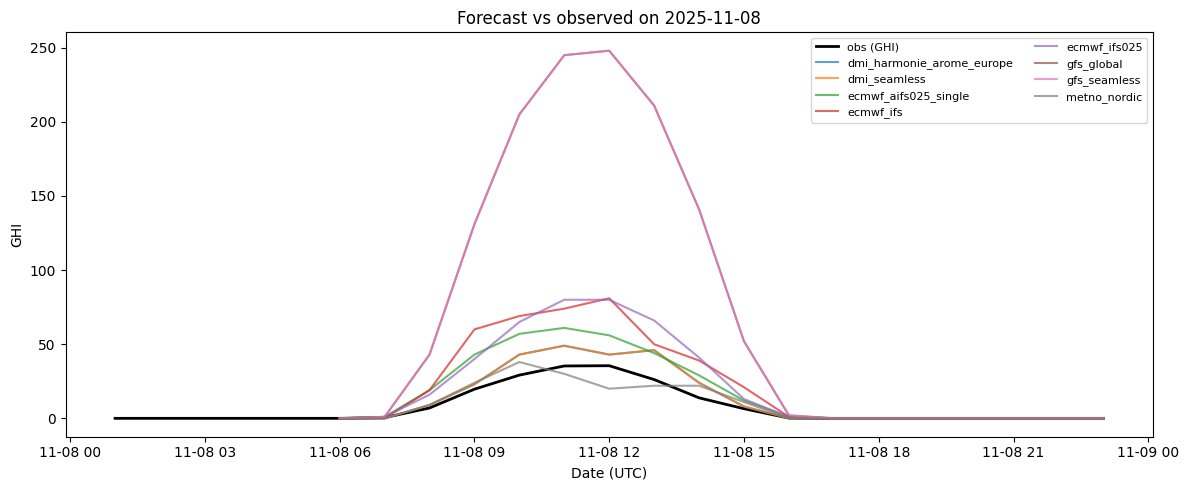

In [186]:
import numpy as np

if aligned.empty:
    raise ValueError("Run the alignment cell first to build 'aligned'")

# Pick earliest day with nonzero GHI
sunny_dates = aligned.loc[aligned['ghi'] > 0, 'date'].dt.floor('D')
if sunny_dates.empty:
    raise ValueError("No nonzero GHI found; check observations")
plot_day = sunny_dates.min()

obs_day = obs_ready[obs_ready['date'].dt.floor('D') == plot_day]
fc_day = aligned[aligned['date'].dt.floor('D') == plot_day]

plt.figure(figsize=(12, 5))
plt.plot(obs_day['date'], obs_day['ghi'], label='obs (GHI)', color='black', linewidth=2)
for model, grp in fc_day.groupby('model'):
    plt.plot(grp['date'], grp['forecast'], label=model, alpha=0.7)
plt.xlabel('Date (UTC)')
plt.ylabel('GHI')
plt.title(f'Forecast vs observed on {plot_day.date()}')
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()



## 5) Error metrics by horizon
- Compute RMSE and bias per model per horizon across all files.
- Visualize RMSE(h) and bias(h) curves; highlight best-performing model per horizon.
- Summaries: table of RMSE/Bias for 24h, 48h, 72h, etc.



### Error metrics by horizon
Compute RMSE and bias per model and horizon; plot curves and key horizons (24/48/72h).


Using forecast file: 06072_20251108T0600.csv


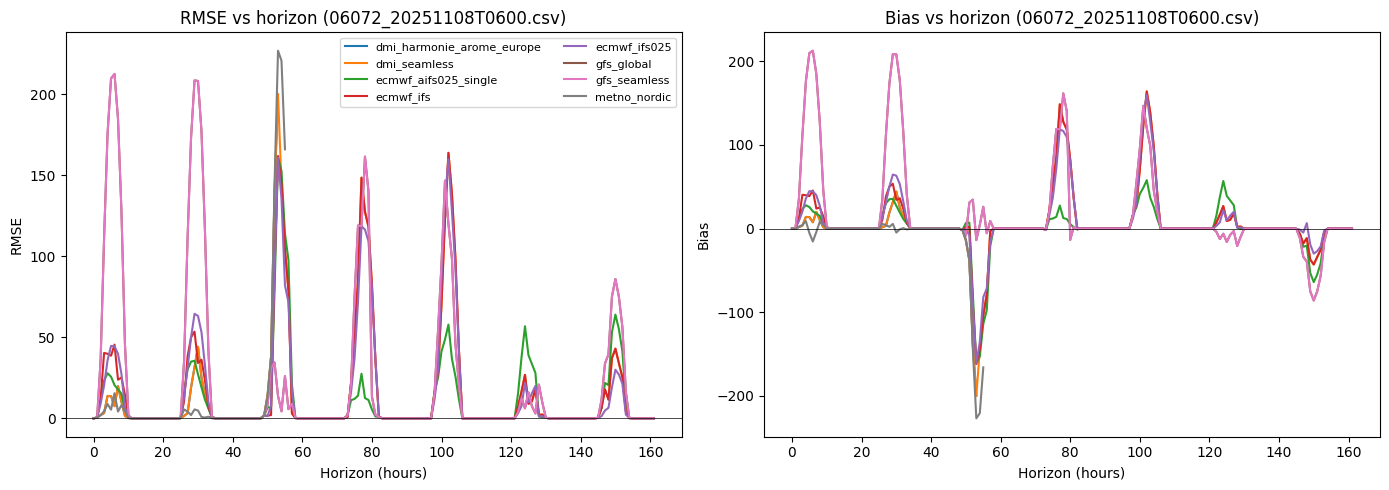

RMSE/Bias at key horizons (rows=model, cols=horizon) for 06072_20251108T0600.csv


rmse           bias          
h_bin                     24.0 48.0 72.0 24.0 48.0 72.0
model                                                  
dmi_harmonie_arome_europe  0.0  0.0  NaN  0.0  0.0  NaN
dmi_seamless               0.0  0.0  0.0  0.0  0.0  0.0
ecmwf_aifs025_single       0.0  0.0  0.0  0.0  0.0  0.0
ecmwf_ifs                  0.0  0.0  0.0  0.0  0.0  0.0
ecmwf_ifs025               0.0  0.0  0.0  0.0  0.0  0.0
gfs_global                 0.0  0.0  0.0  0.0  0.0  0.0
gfs_seamless               0.0  0.0  0.0  0.0  0.0  0.0
metno_nordic               0.0  0.0  NaN  0.0  0.0  NaN

In [187]:

import numpy as np

if aligned.empty:
    raise ValueError("Run the alignment cell first to build 'aligned'")

# Choose which forecast file to analyze (by index in `files`)
selected_idx = 0  # change to another index to pick a different file
if not files:
    raise ValueError("No forecast files loaded in `files`")
selected_file = files[selected_idx].name
print(f"Using forecast file: {selected_file}")

aligned_sel = aligned[aligned['source_file'] == selected_file].copy()
if aligned_sel.empty:
    raise ValueError(f"No aligned rows found for {selected_file}; check selection")

# Bin horizon to whole hours
aligned_sel['h_bin'] = aligned_sel['horizon_hours'].round(0)

# Compute RMSE and bias per model per horizon bin
agg = aligned_sel.groupby(['model', 'h_bin']).agg(
    rmse=('error', lambda x: np.sqrt((x**2).mean())),
    bias=('error', 'mean'),
    n=('error', 'size')
).reset_index()

# Plot RMSE and bias vs horizon (hours)
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
for model, grp in agg.groupby('model'):
    axes[0].plot(grp['h_bin'], grp['rmse'], label=model)
    axes[1].plot(grp['h_bin'], grp['bias'], label=model)
axes[0].set_ylabel('RMSE')
axes[1].set_ylabel('Bias')
for ax in axes:
    ax.set_xlabel('Horizon (hours)')
    ax.axhline(0, color='k', linewidth=0.5)
axes[0].set_title(f'RMSE vs horizon ({selected_file})')
axes[1].set_title(f'Bias vs horizon ({selected_file})')
axes[0].legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

# Summaries at key horizons
key_h = [24, 48, 72]
summary = agg[agg['h_bin'].isin(key_h)].pivot(index='model', columns='h_bin', values=['rmse', 'bias'])
print('RMSE/Bias at key horizons (rows=model, cols=horizon) for', selected_file)
display(summary)



### Average RMSE and bias per model (selected file)


In [188]:

if 'aligned_sel' not in locals():
    raise ValueError("Run the metrics cell above first to set aligned_sel")

avg_metrics = aligned_sel.groupby('model').agg(
    rmse_avg=('error', lambda x: np.sqrt((x**2).mean())),
    bias_avg=('error', 'mean'),
    n=('error', 'size')
).reset_index().sort_values('rmse_avg')

print(f"Average RMSE/Bias for {selected_file} (all horizons)")
display(avg_metrics)


Average RMSE/Bias for 06072_20251108T0600.csv (all horizons)


,model,rmse_avg,bias_avg,n
2,ecmwf_aifs025_single,27.155448,0.065844,162
0,dmi_harmonie_arome_europe,35.014143,-3.268519,54
4,ecmwf_ifs025,37.290052,7.584362,162
3,ecmwf_ifs,39.083753,7.269547,162
1,dmi_seamless,40.133505,4.676955,162
7,metno_nordic,51.890897,-14.252976,56
5,gfs_global,57.347262,18.491770,162
6,gfs_seamless,57.347262,18.491770,162



## 6) Blended forecast attempt
- Try weighted blend (e.g., 80/20 or simple average of top models).
- Optimize weights on a validation slice; compare RMSE/Bias vs best single model.
- Keep method simple and reproducible.



## 7) Poster-ready figures & notes
- Key plots: forecast vs measurement (one representative day); RMSE/Bias vs horizon.
- Brief bullets on why certain models perform better; note limitations.
- Include method steps, data sources, and time labels (UTC, right-binned).
